In [1]:
import traceback

import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import seaborn as sns

import sqlite3 as db

import xml.etree.cElementTree as et

In [2]:
def process_xml_columns(df_new_cols, cols, match, xml_col):
    path = match[xml_col]
    if path is not None:
        root = et.fromstring(path)
        try:
            temp_column_list = []
            for column in cols:
                row_elements = root.findall('.//{}'.format(column))
                row_list = []
                for row in row_elements:
                    row_list.append(row.text)
                temp_column_list.append(row_list)
            df = pd.DataFrame(temp_column_list)
            df = df.transpose()
            df.columns = df_new_cols
            df['match_api_id'] = match.match_api_id
            return df
        except Exception as e:
            print(e)


def create_new_df_from_xml(df, xml_column, df_cols, df_new_cols):
    new_df = pd.DataFrame()
    for index, row in df[df[xml_column].notna()].iterrows():
        df = process_xml_columns(df_new_cols, df_cols, row, xml_column)
        new_df = pd.concat([new_df, df], ignore_index=True)
    return new_df


def fill_nan_goals(df, col1, col2):
    df_col1_nan = df.loc[df[col1].isna()]
    df_col2_nan = df.loc[df[col2].isna()]
    for index, row in df_col1_nan.iterrows():
        df.loc[df.match_api_id == row.match_api_id, col1] = round(
            df.loc[df.home_team == row.home_team][col1].mean())
    for index, row in df_col2_nan.iterrows():
        df.loc[df.match_api_id == row.match_api_id, col2] = round(
            df.loc[df.away_team == row.away_team][col2].mean())
    return df

def missin_values(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    return missing_value_df

In [3]:
conn = db.connect('eu_soccer_database/database.sqlite')

In [4]:
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [5]:
df_detailed_matches = pd.read_sql("SELECT m.match_api_id,"
                                  " Country.name AS country_name,"
                                  " League.name AS league_name,"
                                  " season,"
                                  " stage,"
                                  " m.date,"
                                  " HT.team_long_name AS  home_team,"
                                  " AT.team_long_name AS away_team,"
                                  " home_team_goal,"
                                  " away_team_goal,"
                                  " m.possession,"
                                  " CASE"
                                  " WHEN m.home_team_goal > m.away_team_goal THEN 'H'"
                                  " WHEN m.home_team_goal < m.away_team_goal THEN 'A'"
                                  " WHEN m.home_team_goal = m.away_team_goal THEN 'D'"
                                  " END AS result_match,"
                                  " H6.player_name as home_player_6,"
                                  " H7.player_name as home_player_7,"
                                  " H8.player_name as home_player_8,"
                                  " H9.player_name as home_player_9,"
                                  " H10.player_name as home_player_10,"
                                  " H11.player_name as home_player_11,"
                                  " A6.player_name as away_player_6,"
                                  " A7.player_name as away_player_7,"
                                  " A8.player_name as away_player_8,"
                                  " A9.player_name as away_player_9,"
                                  " A10.player_name as away_player_10,"
                                  " A11.player_name as away_player_11, "
                                  " m.B365H,"
                                  " m.B365D,"
                                  " m.B365A,"
                                  " m.BWH,"
                                  " m.BWD,"
                                  " m.BWA,"
                                  " m.IWH,"
                                  " m.IWD,"
                                  " m.IWA,"
                                  " m.LBH,"
                                  " m.LBD,"
                                  " m.LBA,"
                                  " m.PSH,"
                                  " m.PSD,"
                                  " m.PSA,"
                                  " m.WHH,"
                                  " m.WHD,"
                                  " m.WHA"
                                  " FROM Match as m"
                                  " JOIN Country on Country.id = m.country_id"
                                  " JOIN League on League.id = m.league_id"
                                  " LEFT JOIN Team AS HT on HT.team_api_id = m.home_team_api_id"
                                  " LEFT JOIN Team AS AT on AT.team_api_id = m.away_team_api_id"
                                  " LEFT JOIN Player AS H6 on H6.player_api_id = m.home_player_6"
                                  " LEFT JOIN Player AS H7 on H7.player_api_id = m.home_player_7"
                                  " LEFT JOIN Player AS H8 on H8.player_api_id = m.home_player_8"
                                  " LEFT JOIN Player AS H9 on H9.player_api_id = m.home_player_9"
                                  " LEFT JOIN Player AS H10 on H10.player_api_id = m.home_player_10"
                                  " LEFT JOIN Player AS H11 on H11.player_api_id = m.home_player_11"
                                  " LEFT JOIN Player AS A6 on A6.player_api_id = m.away_player_6"
                                  " LEFT JOIN Player AS A7 on A7.player_api_id = m.away_player_7"
                                  " LEFT JOIN Player AS A8 on A8.player_api_id = m.away_player_8"
                                  " LEFT JOIN Player AS A9 on A9.player_api_id = m.away_player_9"
                                  " LEFT JOIN Player AS A10 on A10.player_api_id = m.away_player_10"
                                  " LEFT JOIN Player AS A11 on A11.player_api_id = m.away_player_11"
                                  " WHERE League.id IN (1729, 4769, 7809, 10257, 21518)"
                                  " AND m.possession IS NOT NULL"
                                  " ORDER by date;", conn)

In [6]:
profile = ProfileReport(df_detailed_matches, title='Detailed matches')
# profile

In [7]:
df_detailed_matches['date'] = pd.to_datetime(df_detailed_matches['date']).dt.date
df_detailed_matches[
    ['country_name', 'league_name', 'season', 'home_team', 'away_team', 'result_match', 'home_player_6',
     'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_6',
     'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11', 'possession']] = df_detailed_matches[
    ['country_name', 'league_name', 'season', 'home_team', 'away_team', 'result_match', 'home_player_6',
     'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_6',
     'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11', 'possession']].astype(
    'category')

In [8]:
df_detailed_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13567 entries, 0 to 13566
Data columns (total 42 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   match_api_id    13567 non-null  int64   
 1   country_name    13567 non-null  category
 2   league_name     13567 non-null  category
 3   season          13567 non-null  category
 4   stage           13567 non-null  int64   
 5   date            13567 non-null  object  
 6   home_team       13567 non-null  category
 7   away_team       13567 non-null  category
 8   home_team_goal  13567 non-null  int64   
 9   away_team_goal  13567 non-null  int64   
 10  possession      13567 non-null  category
 11  result_match    13567 non-null  category
 12  home_player_6   13541 non-null  category
 13  home_player_7   13521 non-null  category
 14  home_player_8   13528 non-null  category
 15  home_player_9   13534 non-null  category
 16  home_player_10  13499 non-null  category
 17  home_player_

In [9]:
teams = pd.unique(df_detailed_matches[['home_team', 'away_team']].values.ravel('K'))

try:
    for team in teams:
        mask_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        matches = df_detailed_matches.loc[mask_team_matches]
        matches = matches.sort_values(by='date')

        for index, row in matches.iterrows():
            previous_match_goals = row['home_team_goal'] if team == row['home_team'] else row['away_team_goal']
            next_match = matches.loc[matches['match_api_id'].shift(1) == row['match_api_id']].dropna(how='all')
            if not next_match.empty:
                if team == next_match['home_team'].values:
                    df_detailed_matches.loc[
                        df_detailed_matches['match_api_id'] == next_match.iloc[0]['match_api_id'], 'lm_goals_home'] = previous_match_goals
                else:
                    df_detailed_matches.loc[
                        df_detailed_matches['match_api_id'] == next_match.iloc[0]['match_api_id'], 'lm_goals_away'] = previous_match_goals

except Exception as e:
    e.with_traceback()
    print(e)

In [10]:
df_detailed_matches = fill_nan_goals(df_detailed_matches, 'lm_goals_home', 'lm_goals_away')

In [11]:
try:
    for team in teams:
        mask_find_team_matches = (df_detailed_matches['home_team'] == team) | (
                df_detailed_matches['away_team'] == team)
        team_matches = df_detailed_matches.loc[mask_find_team_matches]
        team_matches = team_matches.sort_values(by='date')

        for index, row in team_matches.iterrows():
            mask_home = ((team_matches['home_team'] == row['home_team']) & (team_matches['date'] < row['date']))
            mask_away = ((team_matches['away_team'] == row['away_team']) & (team_matches['date'] < row['date']))
            mask_both = (team_matches['date'] < row['date'])

            avg_l5m_hh = team_matches.loc[mask_home].iloc[-5:]['home_team_goal'].mean()
            avg_l5m_aa = team_matches.loc[mask_away].iloc[-5:]['away_team_goal'].mean()
            l5_m = team_matches.loc[mask_both].iloc[-5:]

            goals = []

            for idx, r in l5_m.iterrows():
                if r['home_team'] == team:
                    goals.append(r['home_team_goal'])
                else:
                    goals.append(r['away_team_goal'])

            avg_l5_m = np.nan if len(goals) == 0 else sum(goals) / len(goals)
            if team == row['home_team']:
                df_detailed_matches.loc[
                    df_detailed_matches['match_api_id'] == row['match_api_id'], 'avg_l5m_hh'] = avg_l5m_hh
                df_detailed_matches.loc[
                    df_detailed_matches['match_api_id'] == row['match_api_id'], 'avg_l5m_h'] = avg_l5_m
            else:
                df_detailed_matches.loc[
                    df_detailed_matches['match_api_id'] == row['match_api_id'], 'avg_l5m_aa'] = avg_l5m_aa
                df_detailed_matches.loc[
                    df_detailed_matches['match_api_id'] == row['match_api_id'], 'avg_l5m_a'] = avg_l5_m
except Exception as e:
    print(e)

In [12]:
df_detailed_matches = fill_nan_goals(df_detailed_matches, 'avg_l5m_h', 'avg_l5m_hh')
df_detailed_matches = fill_nan_goals(df_detailed_matches, 'avg_l5m_a', 'avg_l5m_aa')

In [13]:
# df_detailed_matches['avg_l5m_hh'] = round(df_detailed_matches['avg_l5m_hh'])
# df_detailed_matches['avg_l5m_hh'] = round(df_detailed_matches['avg_l5m_hh'])
# df_detailed_matches['avg_l5m_aa'] = round(df_detailed_matches['avg_l5m_aa'])
# df_detailed_matches['avg_l5m_aam'] = round(df_detailed_matches['avg_l5m_aam'])

In [14]:
try:
    for team in teams:
        mask_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        team_matches = df_detailed_matches.loc[mask_team_matches]
        team_matches = team_matches.sort_values(by='date', ascending=False)

        for index, row in team_matches.iterrows():
            mask_both = (team_matches['date'] < row['date'])
            matches_filtering_by_date = team_matches.loc[mask_both]
            win_counter = 0

            for idx in range(len(matches_filtering_by_date)):
                if team == matches_filtering_by_date.iloc[idx]['home_team']:
                    match_goals = matches_filtering_by_date[['home_team_goal', 'away_team_goal']].iloc[idx]
                    if match_goals.loc['home_team_goal'] > match_goals.loc['away_team_goal']:
                        win_counter = win_counter + 1
                    else:
                        break
                else:
                    match_goals = matches_filtering_by_date[['home_team_goal', 'away_team_goal']].iloc[idx]
                    if match_goals.loc['home_team_goal'] < match_goals.loc['away_team_goal']:
                        win_counter = win_counter + 1
                    else:
                        break
            if team == row['home_team']:
                df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'streak_last_wh'] = win_counter
            else:
                df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'streak_last_wa'] = win_counter
except Exception as e:
    print(e)

In [15]:
try:
    for team in teams:
        mask_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        team_matches = df_detailed_matches.loc[mask_team_matches]
        team_matches = team_matches.sort_values(by='date', ascending=False)

        for index, row in team_matches.iterrows():
            mask_both = (team_matches['date'] < row['date'])
            matches_filtering_by_date = team_matches.loc[mask_both]
            lose_counter = 0

            for idx in range(len(matches_filtering_by_date)):
                if team == matches_filtering_by_date.iloc[idx]['home_team']:
                    match_goals = matches_filtering_by_date[['home_team_goal', 'away_team_goal']].iloc[idx]
                    if match_goals.loc['home_team_goal'] > match_goals.loc['away_team_goal']:
                        break
                    else:
                        lose_counter = lose_counter + 1
                else:
                    match_goals = matches_filtering_by_date[['home_team_goal', 'away_team_goal']].iloc[idx]
                    if match_goals.loc['home_team_goal'] < match_goals.loc['away_team_goal']:
                        break
                    else:
                        lose_counter = lose_counter + 1

            if team == row['home_team']:
                df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'streak_last_lh'] = lose_counter
            else:
                df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'streak_last_la'] = lose_counter
except Exception as e:
    print(e)

In [16]:
columns_possession = ['awaypos', 'homepos', 'subtype', 'elapsed']
new_columns_possession = ['awaypos', 'homepos', 'subtype', 'elapsed']
df_possession = create_new_df_from_xml(df_detailed_matches, 'possession', columns_possession, new_columns_possession)

In [17]:
df_possession[['awaypos', 'homepos']] = df_possession[['awaypos', 'homepos']].fillna(0).astype('int')
df_possession[['awaypos', 'homepos']] = df_possession[['awaypos', 'homepos']].replace(0, np.nan)
df_possession['awaypos'] = df_possession['awaypos'].fillna(df_possession.groupby('match_api_id')['awaypos'].transform('mean'))
df_possession['homepos'] = df_possession['homepos'].fillna(df_possession.groupby('match_api_id')['homepos'].transform('mean'))
df_possession[['awaypos', 'homepos']] = df_possession[['awaypos', 'homepos']].astype('int')

In [18]:
# missin_values(df_detailed_matches)

In [19]:
df_possession = df_possession.loc[(df_possession['elapsed'] == '90') | df_possession['elapsed'].isna()]
df_possession = df_possession.groupby(by=['match_api_id'])[['awaypos', 'homepos']].mean().astype(int)
df_possession = df_possession.reset_index(level=0)

In [20]:
df_detailed_matches = pd.merge(df_detailed_matches, df_possession, how='left', on='match_api_id')

In [21]:
df_detailed_matches_nan_possession = df_detailed_matches.loc[(df_detailed_matches['awaypos'].isna()) | (df_detailed_matches['homepos'].isna())]

In [22]:
for index, row in df_detailed_matches_nan_possession.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']

    mask_all_matches_between_teams = ((df_detailed_matches['home_team'] == home_team) | (df_detailed_matches['away_team'] == home_team)) &\
                                     ((df_detailed_matches['home_team'] == away_team) | (df_detailed_matches['away_team'] == away_team))
    all_matches_between_teams = df_detailed_matches.loc[mask_all_matches_between_teams]

    home_possessions = []
    away_possessions = []

    for idx, r in all_matches_between_teams.iterrows():
        if (r['home_team'] == home_team) & (not pd.isna(r['homepos'])):
            home_possessions.append(r['homepos'])
        elif (r['away_team'] == home_team) & (not pd.isna(r['awaypos'])):
            home_possessions.append(r['awaypos'])

        if (r['home_team'] == away_team) & (not pd.isna(r['homepos'])):
            away_possessions.append(r['homepos'])
        elif (r['away_team'] == away_team) & (not pd.isna(r['awaypos'])):
            away_possessions.append(r['awaypos'])

    if (len(home_possessions) == 0) | (len(away_possessions) == 0):
        res = df_detailed_matches.drop(df_detailed_matches[df_detailed_matches.match_api_id == row.match_api_id].index)
    else:
        avg_possession_home = sum(home_possessions) / len(home_possessions)
        avg_possession_away = sum(away_possessions) / len(away_possessions)
        df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'homepos'] = int(avg_possession_home)
        df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'awaypos'] = int(avg_possession_away)

In [23]:
df_detailed_matches['awaypos'] = df_detailed_matches['awaypos'].fillna(df_detailed_matches.groupby(['away_team'])['awaypos'].transform('mean'))
df_detailed_matches['homepos'] = df_detailed_matches['homepos'].fillna(df_detailed_matches.groupby(['home_team'])['homepos'].transform('mean'))

df_detailed_matches['awaypos'] = df_detailed_matches['awaypos'].fillna(df_detailed_matches.groupby(['league_name'])['awaypos'].transform('mean'))
df_detailed_matches['homepos'] = df_detailed_matches['homepos'].fillna(df_detailed_matches.groupby(['league_name'])['homepos'].transform('mean'))

In [24]:
teams = pd.unique(df_detailed_matches[['home_team', 'away_team']].values.ravel('K'))

try:
    for team in teams:
        mask_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        matches = df_detailed_matches.loc[mask_team_matches]
        matches = matches.sort_values(by='date')

        for index, row in matches.iterrows():
            previous_match_possession = row['homepos'] if team == row['home_team'] else row['awaypos']
            next_match = matches.loc[matches['match_api_id'].shift(1) == row['match_api_id']].dropna(how='all')

            if not next_match.empty:
                if team == next_match['home_team'].values:
                    df_detailed_matches.loc[df_detailed_matches['match_api_id'] == next_match['match_api_id'].values[0],
                                            'last_match_possession_home'] = previous_match_possession
                else:
                    df_detailed_matches.loc[df_detailed_matches['match_api_id'] == next_match['match_api_id'].values[0],
                                            'last_match_possession_away'] = previous_match_possession

except Exception as e:
    print(e)

In [25]:
df_detailed_matches['last_match_possession_away'] = df_detailed_matches['last_match_possession_away'].fillna(
    df_detailed_matches.groupby(['away_team'])['last_match_possession_away'].transform('mean'))
df_detailed_matches['last_match_possession_home'] = df_detailed_matches['last_match_possession_home'].fillna(
    df_detailed_matches.groupby(['home_team'])['last_match_possession_home'].transform('mean'))

df_detailed_matches['last_match_possession_away'] = df_detailed_matches['last_match_possession_away'].fillna(
    df_detailed_matches.groupby(['league_name'])['last_match_possession_away'].transform('mean'))
df_detailed_matches['last_match_possession_home'] = df_detailed_matches['last_match_possession_home'].fillna(
    df_detailed_matches.groupby(['league_name'])['last_match_possession_home'].transform('mean'))

In [26]:
try:
    for team in teams:
        mask_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        matches = df_detailed_matches.loc[mask_team_matches]
        matches = matches.sort_values(by='date')

        for index, row in matches.iterrows():
            match_date = row['date']
            next_match = matches.loc[matches['match_api_id'].shift(1) == row['match_api_id']].dropna(how='all')

            if not next_match.empty:
                days_last_match = delta = next_match['date'].iloc[0] - match_date

                if team == next_match.iloc[0]['home_team']:
                    df_detailed_matches.loc[df_detailed_matches['match_api_id'] == next_match['match_api_id'].values[0],
                                            'days_since_lmh'] = days_last_match.days
                else:
                    df_detailed_matches.loc[df_detailed_matches['match_api_id'] == next_match['match_api_id'].values[0],
                                            'days_since_lma'] = days_last_match.days

except Exception as e:
    print(e)

In [28]:
df_detailed_matches['days_since_lmh'] = df_detailed_matches['days_since_lmh'].fillna(
    df_detailed_matches.groupby(['league_name'])['days_since_lmh'].transform('mean').astype(int))

df_detailed_matches['days_since_lma'] = df_detailed_matches['days_since_lma'].fillna(
    df_detailed_matches.groupby(['league_name'])['days_since_lma'].transform('mean').astype(int))

In [ ]:
# date_temp = df_detailed_matches[['match_api_id', 'stage', 'date', 'home_team', 'away_team', 'days_since_lmh', 'days_since_lma']]
# TODO add func to handle outliers
# outliers_date = date_temp.loc[(date_temp.days_since_lma > 50) | (date_temp.days_since_lmh > 50)].apply(lambda row: fix_lm_date_outlier(row))

In [29]:
for index, row in df_detailed_matches.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']

    mask_all_matches_between_teams = ((df_detailed_matches['home_team'] == home_team) | (df_detailed_matches['away_team'] == home_team)) & \
                                     ((df_detailed_matches['home_team'] == away_team) | (df_detailed_matches['away_team'] == away_team))
    all_matches_between_teams = df_detailed_matches.loc[mask_all_matches_between_teams]

    for idx, r in all_matches_between_teams.iterrows():
        next_match = all_matches_between_teams.loc[all_matches_between_teams['match_api_id'].shift(1) == r['match_api_id']].dropna(how='all')
        lm_winner = ''
        if not next_match.empty:
            if r['home_team_goal'] > r['away_team_goal']:
                lm_winner = r['home_team']
            elif r['home_team_goal'] == r['away_team_goal']:
                lm_winner = 'Draw'
            else:
                lm_winner = r['away_team']

            df_detailed_matches.loc[df_detailed_matches['match_api_id'] == next_match.iloc[0]['match_api_id'], 'lm_winner'] = lm_winner

df_detailed_matches['lm_winner'].astype(str)

0                nan
1                nan
2                nan
3                nan
4                nan
            ...     
13562      Getafe CF
13563       SD Eibar
13564           Draw
13565     Levante UD
13566    Bournemouth
Name: lm_winner, Length: 13567, dtype: object

In [30]:
df_detailed_matches_nan_lm_winner = df_detailed_matches.loc[df_detailed_matches.lm_winner.isna()]

In [31]:
for index, row in df_detailed_matches_nan_lm_winner.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']

    mask_all_matches_between_teams = ((df_detailed_matches['home_team'] == home_team) | (
            df_detailed_matches['away_team'] == home_team)) & ((df_detailed_matches['home_team'] == away_team) | (
            df_detailed_matches['away_team'] == away_team))
    all_matches_between_teams = df_detailed_matches.loc[mask_all_matches_between_teams]
    all_matches_between_teams = all_matches_between_teams.sort_values(by='date')

    lm_winner = all_matches_between_teams.mode()['lm_winner'][0]
    df_detailed_matches.loc[df_detailed_matches['match_api_id'] == row['match_api_id'], 'lm_winner'] = lm_winner


In [32]:
def get_points(row, team):
    if row['home_team'] == team:
        if row['home_team_goal'] > row['away_team_goal']:
            return 3
        elif row['home_team_goal'] < row['away_team_goal']:
            return 0
        else:
            return 1
    else:
        if row['home_team_goal'] > row['away_team_goal']:
            return 0
        elif row['home_team_goal'] < row['away_team_goal']:
            return 3
        else:
            return 1

In [34]:
try:
    for team in teams:
        mask_find_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        team_matches = df_detailed_matches.loc[mask_find_team_matches]
        team_matches = team_matches.sort_values(by='date')

        for index, row in team_matches.iterrows():
            mask = (((df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)) & (team_matches['date'] < row['date']))

            point_list = team_matches.loc[mask].iloc[-5:].apply(lambda row: get_points(row, team), axis=1)
            avg_points_l5m = np.nan

            if len(point_list) > 4:
                avg_points_l5m = point_list.mean()

            if row['home_team'] == team:
                df_detailed_matches.loc[df_detailed_matches.match_api_id == row.match_api_id, 'avg_points_l5m_h'] = avg_points_l5m
            else:
                df_detailed_matches.loc[df_detailed_matches.match_api_id == row.match_api_id, 'avg_points_l5m_a'] = avg_points_l5m
except Exception as e:
    e.with_traceback()
    print(e)

In [35]:
df_detailed_matches.season.unique()

['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013', '2013/2014', '2014/2015', '2015/2016']
Categories (8, object): ['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013', '2013/2014', '2014/2015', '2015/2016']

In [36]:
try:
    for team in teams:
        mask_find_team_matches = (df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)
        team_matches = df_detailed_matches.loc[mask_find_team_matches]
        team_matches = team_matches.sort_values(by='date')
        seasons_unique = team_matches.season.unique()

        for season in seasons_unique:
            season_matches = team_matches.loc[team_matches.season == season]
            for index, row in season_matches.iterrows():
                mask = (((df_detailed_matches['home_team'] == team) | (df_detailed_matches['away_team'] == team)) & (team_matches['date'] < row['date']))

                point_list = season_matches.loc[mask].apply(lambda row: get_points(row, team), axis=1)
                points = 0

                if len(point_list):
                    points = point_list.sum()

                if row['home_team'] == team:
                    df_detailed_matches.loc[df_detailed_matches.match_api_id == row.match_api_id, 'points_home'] = points
                else:
                    df_detailed_matches.loc[df_detailed_matches.match_api_id == row.match_api_id, 'points_away'] = points
except Exception as e:
    e.with_traceback()
    print(e)

In [37]:
df_detailed_matches['avg_points_l5m_h'] = df_detailed_matches['avg_points_l5m_h'].fillna(
    df_detailed_matches.groupby(['season', 'home_team'])['avg_points_l5m_h'].transform('mean'))

df_detailed_matches['avg_points_l5m_a'] = df_detailed_matches['avg_points_l5m_a'].fillna(
    df_detailed_matches.groupby(['season', 'away_team'])['avg_points_l5m_a'].transform('mean'))


In [49]:
df_detailed_matches = df_detailed_matches.drop(['home_team_goal', 'away_team_goal', 'possession', 'points_home', 'points_away'], axis=1)
# te = df_detailed_matches.loc[((df_detailed_matches.home_team == 'Chelsea') | (df_detailed_matches.away_team == 'Chelsea'))][
#     ['home_team', 'away_team', 'stage', 'date', 'result_match', 'points_home', 'points_away', 'avg_points_l5m_h', 'avg_points_l5m_a']]

In [52]:
df_detailed_matches.describe(exclude="number")

,country_name,league_name,season,date,home_team,away_team,result_match,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,lm_winner
count,13567,13567,13567,13567,13567,13567,13567,13541,13521,13528,13534,13499,13510,13528,13528,13520,13525,13508,13499,13531
unique,5,5,8,1343,160,160,3,1901,1710,2102,2028,1857,1365,1958,1809,2193,2154,2017,1443,160
top,England,England Premier League,2013/2014,2012-05-13,Chievo Verona,Athletic Club de Bilbao,H,Xavi Hernandez,Sergio Busquets,Andres Iniesta,Mesut Oezil,Diego Castro,Antonio Di Natale,Xavi Hernandez,Sergio Busquets,Pedro Leon,Mesut Oezil,Zlatan Ibrahimovic,Aritz Aduriz,Draw
freq,3040,3040,1826,38,152,152,6305,80,85,75,85,83,103,85,100,69,86,77,91,3402


In [57]:
unique_num_values = df_detailed_matches.select_dtypes(include=['number']).nunique().sort_values()

<AxesSubplot:title={'center':'Unique values per feature'}>

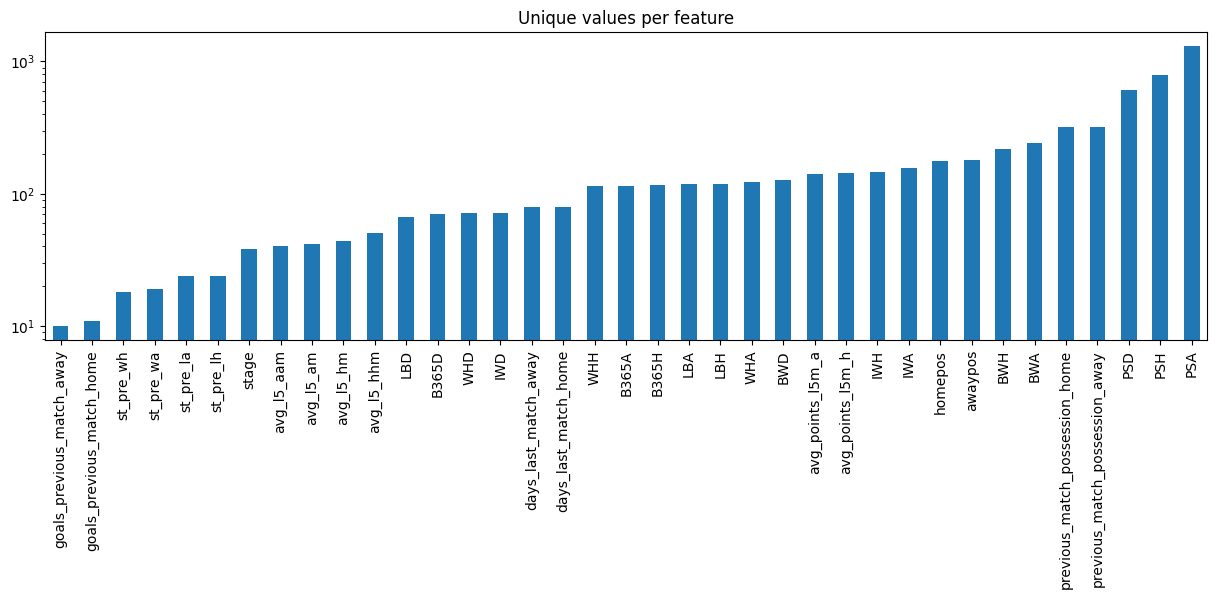

In [59]:
unique_num_values.drop(['match_api_id']).plot.bar(logy=True, figsize=(15,4), title='Unique values per feature')
# missin_values(df_detailed_matches).sort_values(by='percent_missing', ascending=False).head(15)

In [61]:
n_duplicates = df_detailed_matches.drop(['match_api_id'], axis=1).duplicated().sum()
print(f'You have to seem {n_duplicates} in db.')

You have to seem 0 in db.


In [65]:
missin_values(df_detailed_matches).sort_values(by='percent_missing', ascending=False).head(10)

,column_name,percent_missing
PSA,PSA,46.259306
PSD,PSD,46.259306
PSH,PSH,46.259306
away_player_11,away_player_11,0.501216
home_player_10,home_player_10,0.501216
away_player_10,away_player_10,0.434879
home_player_11,home_player_11,0.420137
away_player_8,away_player_8,0.346429
home_player_7,home_player_7,0.339058
IWD,IWD,0.316946
